In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [23]:
Link = 'Electricity.csv'
df = pd.read_csv(Link)

In [24]:
df.head()

,Start time UTC,End time UTC,Start time UTC+03:00,End time UTC+03:00,Electricity consumption in Finland
0,2015-12-31 21:00:00,2015-12-31 22:00:00,2016-01-01 00:00:00,2016-01-01 01:00:00,10800.0
1,2015-12-31 22:00:00,2015-12-31 23:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00,10431.0
2,2015-12-31 23:00:00,2016-01-01 00:00:00,2016-01-01 02:00:00,2016-01-01 03:00:00,10005.0
3,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 03:00:00,2016-01-01 04:00:00,9722.0
4,2016-01-01 01:00:00,2016-01-01 02:00:00,2016-01-01 04:00:00,2016-01-01 05:00:00,9599.0


In [25]:
df.tail()

,Start time UTC,End time UTC,Start time UTC+03:00,End time UTC+03:00,Electricity consumption in Finland
52961,2021-12-31 16:00:00,2021-12-31 17:00:00,2021-12-31 19:00:00,2021-12-31 20:00:00,11447.0
52962,2021-12-31 17:00:00,2021-12-31 18:00:00,2021-12-31 20:00:00,2021-12-31 21:00:00,11237.0
52963,2021-12-31 18:00:00,2021-12-31 19:00:00,2021-12-31 21:00:00,2021-12-31 22:00:00,10914.0
52964,2021-12-31 19:00:00,2021-12-31 20:00:00,2021-12-31 22:00:00,2021-12-31 23:00:00,10599.0
52965,2021-12-31 20:00:00,2021-12-31 21:00:00,2021-12-31 23:00:00,2022-01-01 00:00:00,10812.0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Start time UTC                      52966 non-null  object 
 1   End time UTC                        52966 non-null  object 
 2   Start time UTC+03:00                52966 non-null  object 
 3   End time UTC+03:00                  52966 non-null  object 
 4   Electricity consumption in Finland  52966 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.0+ MB


In [27]:
print(df.describe(), "\n")

       Electricity consumption in Finland
count                        52966.000000
mean                          9488.750519
std                           1576.241673
min                           5341.000000
25%                           8322.000000
50%                           9277.000000
75%                          10602.000000
max                          15105.000000 



## Feature Selection

In [28]:
del df["Start time UTC"]
del df["End time UTC"]
del df["Start time UTC+03:00"]
df.rename(columns={"End time UTC+03:00":"DateTime","Electricity consumption in Finland":"Consumption"},inplace=True)
print(df.head(5))

              DateTime  Consumption
0  2016-01-01 01:00:00      10800.0
1  2016-01-01 02:00:00      10431.0
2  2016-01-01 03:00:00      10005.0
3  2016-01-01 04:00:00       9722.0
4  2016-01-01 05:00:00       9599.0


In [29]:
dataset = df
dataset["Month"] = pd.to_datetime(df["DateTime"]).dt.month
dataset["Year"] = pd.to_datetime(df["DateTime"]).dt.year
dataset["Date"] = pd.to_datetime(df["DateTime"]).dt.date
dataset["Time"] = pd.to_datetime(df["DateTime"]).dt.time
dataset["Day"] = pd.to_datetime(df["DateTime"]).dt.day_name()
dataset = df.set_index("DateTime")
dataset.index = pd.to_datetime(dataset.index)

In [30]:
dataset.head()

,Consumption,Month,Year,Date,Time,Day
DateTime,,,,,,
2016-01-01 01:00:00,10800.0,1,2016,2016-01-01,01:00:00,Friday
2016-01-01 02:00:00,10431.0,1,2016,2016-01-01,02:00:00,Friday
2016-01-01 03:00:00,10005.0,1,2016,2016-01-01,03:00:00,Friday
2016-01-01 04:00:00,9722.0,1,2016,2016-01-01,04:00:00,Friday
2016-01-01 05:00:00,9599.0,1,2016,2016-01-01,05:00:00,Friday


In [31]:
print("")
print("Total Number of Years: ", dataset.Year.nunique() )
print(dataset.Year.unique())


Total Number of Years:  7
[2016 2017 2018 2019 2020 2021 2022]


In [32]:
dataset = dataset[71:-121]
dataset.tail()

,Consumption,Month,Year,Date,Time,Day
DateTime,,,,,,
2021-12-26 19:00:00,12550.0,12,2021,2021-12-26,19:00:00,Sunday
2021-12-26 20:00:00,12622.0,12,2021,2021-12-26,20:00:00,Sunday
2021-12-26 21:00:00,12574.0,12,2021,2021-12-26,21:00:00,Sunday
2021-12-26 22:00:00,12384.0,12,2021,2021-12-26,22:00:00,Sunday
2021-12-26 23:00:00,12044.0,12,2021,2021-12-26,23:00:00,Sunday


## Data Visualisation

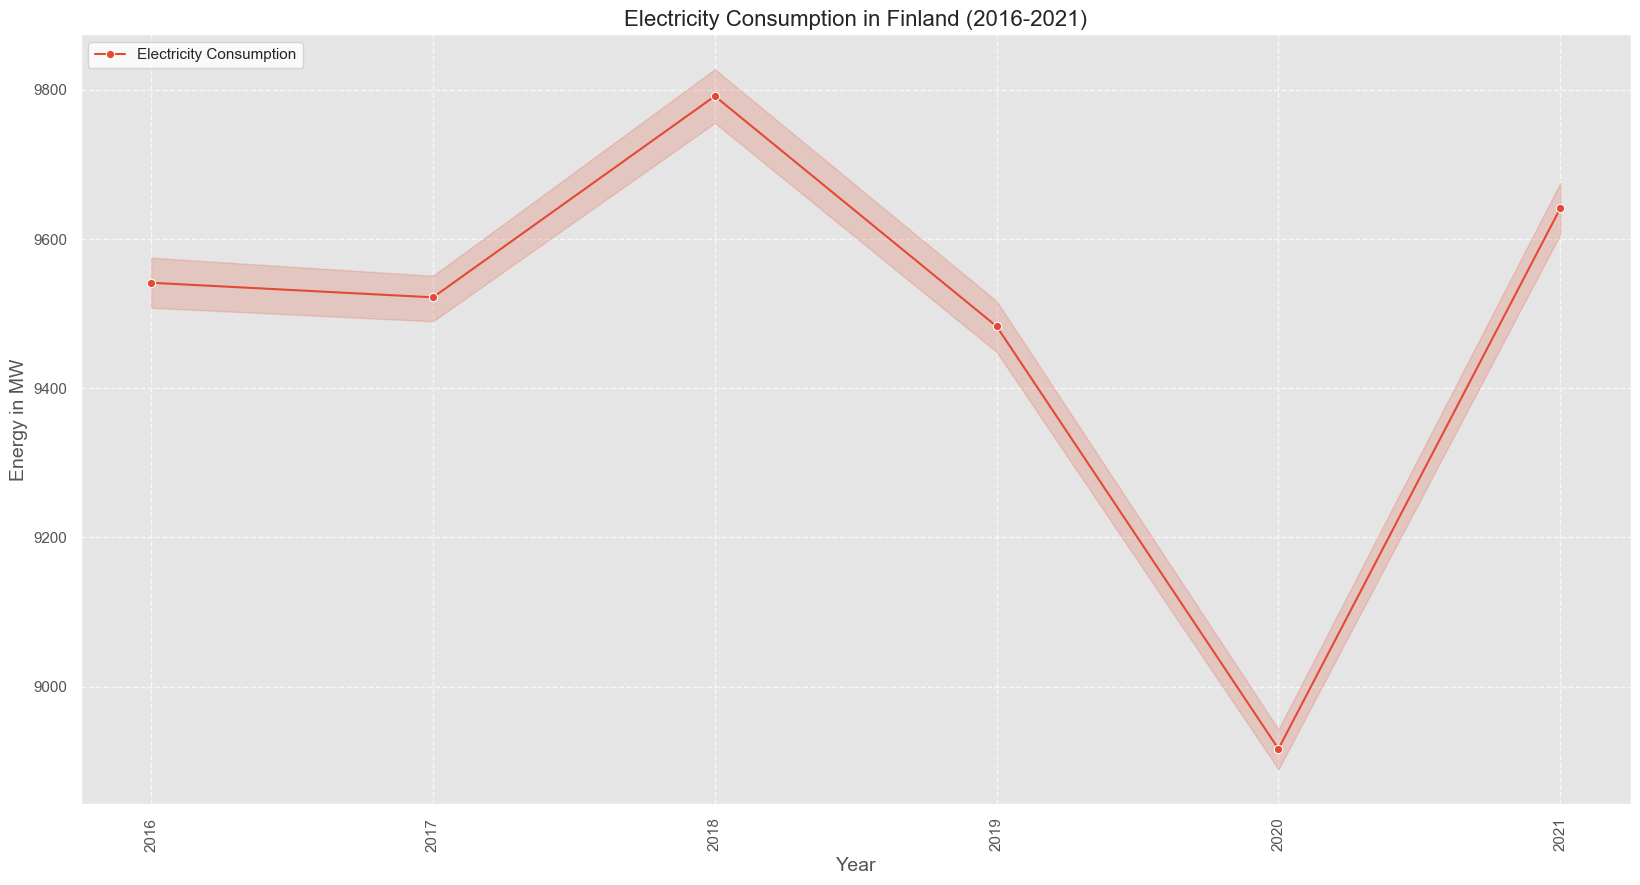

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

# Apply style
style.use("ggplot")

# Create figure and axes
fig, ax = plt.subplots(figsize=(20,10))

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Line plot with marker
sns.lineplot(x=dataset["Year"], y=dataset["Consumption"], data=dataset, marker='o', ax=ax)

# Titles and labels
plt.title("Electricity Consumption in Finland (2016-2021)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Energy in MW", fontsize=14)

# Customize legend
plt.legend(["Electricity Consumption"], loc="upper left")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show grid
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()


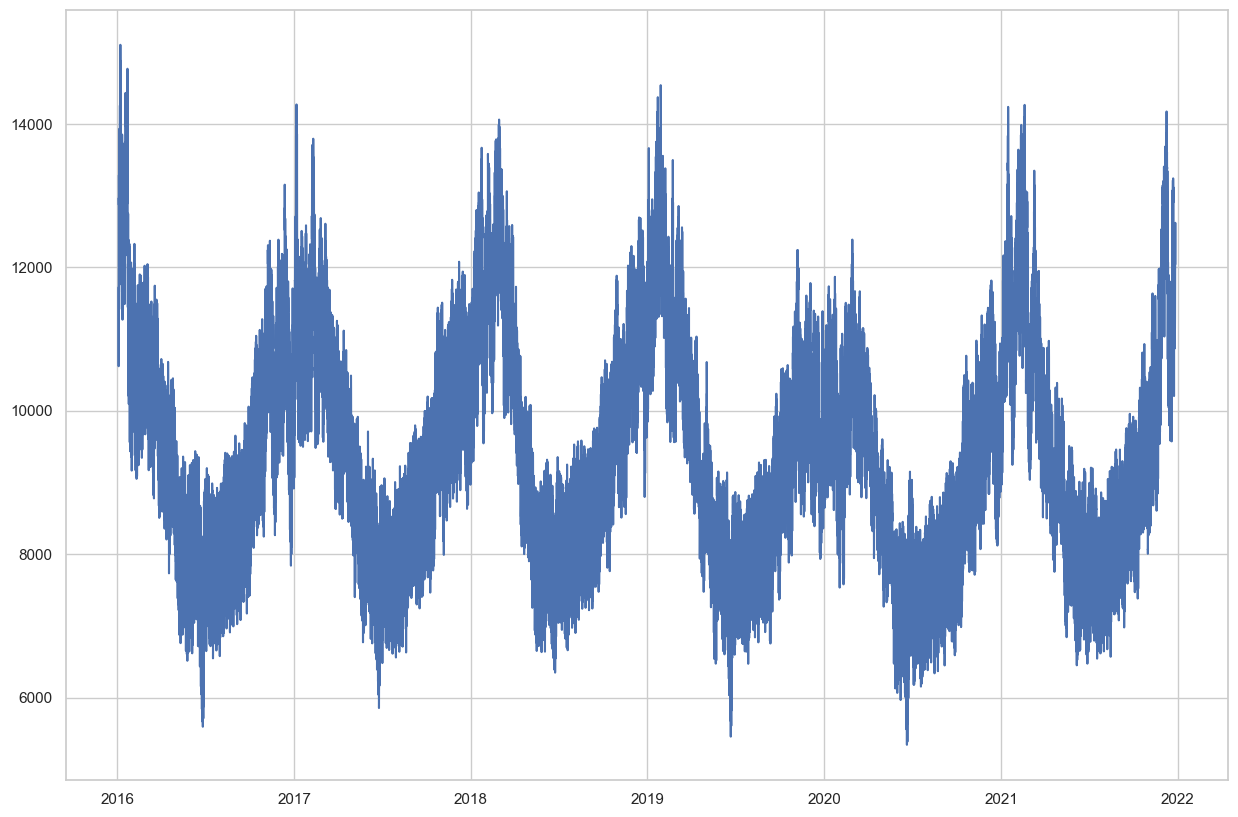

In [34]:
plt.figure(figsize=(15,10))
plt.plot(dataset["Consumption"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


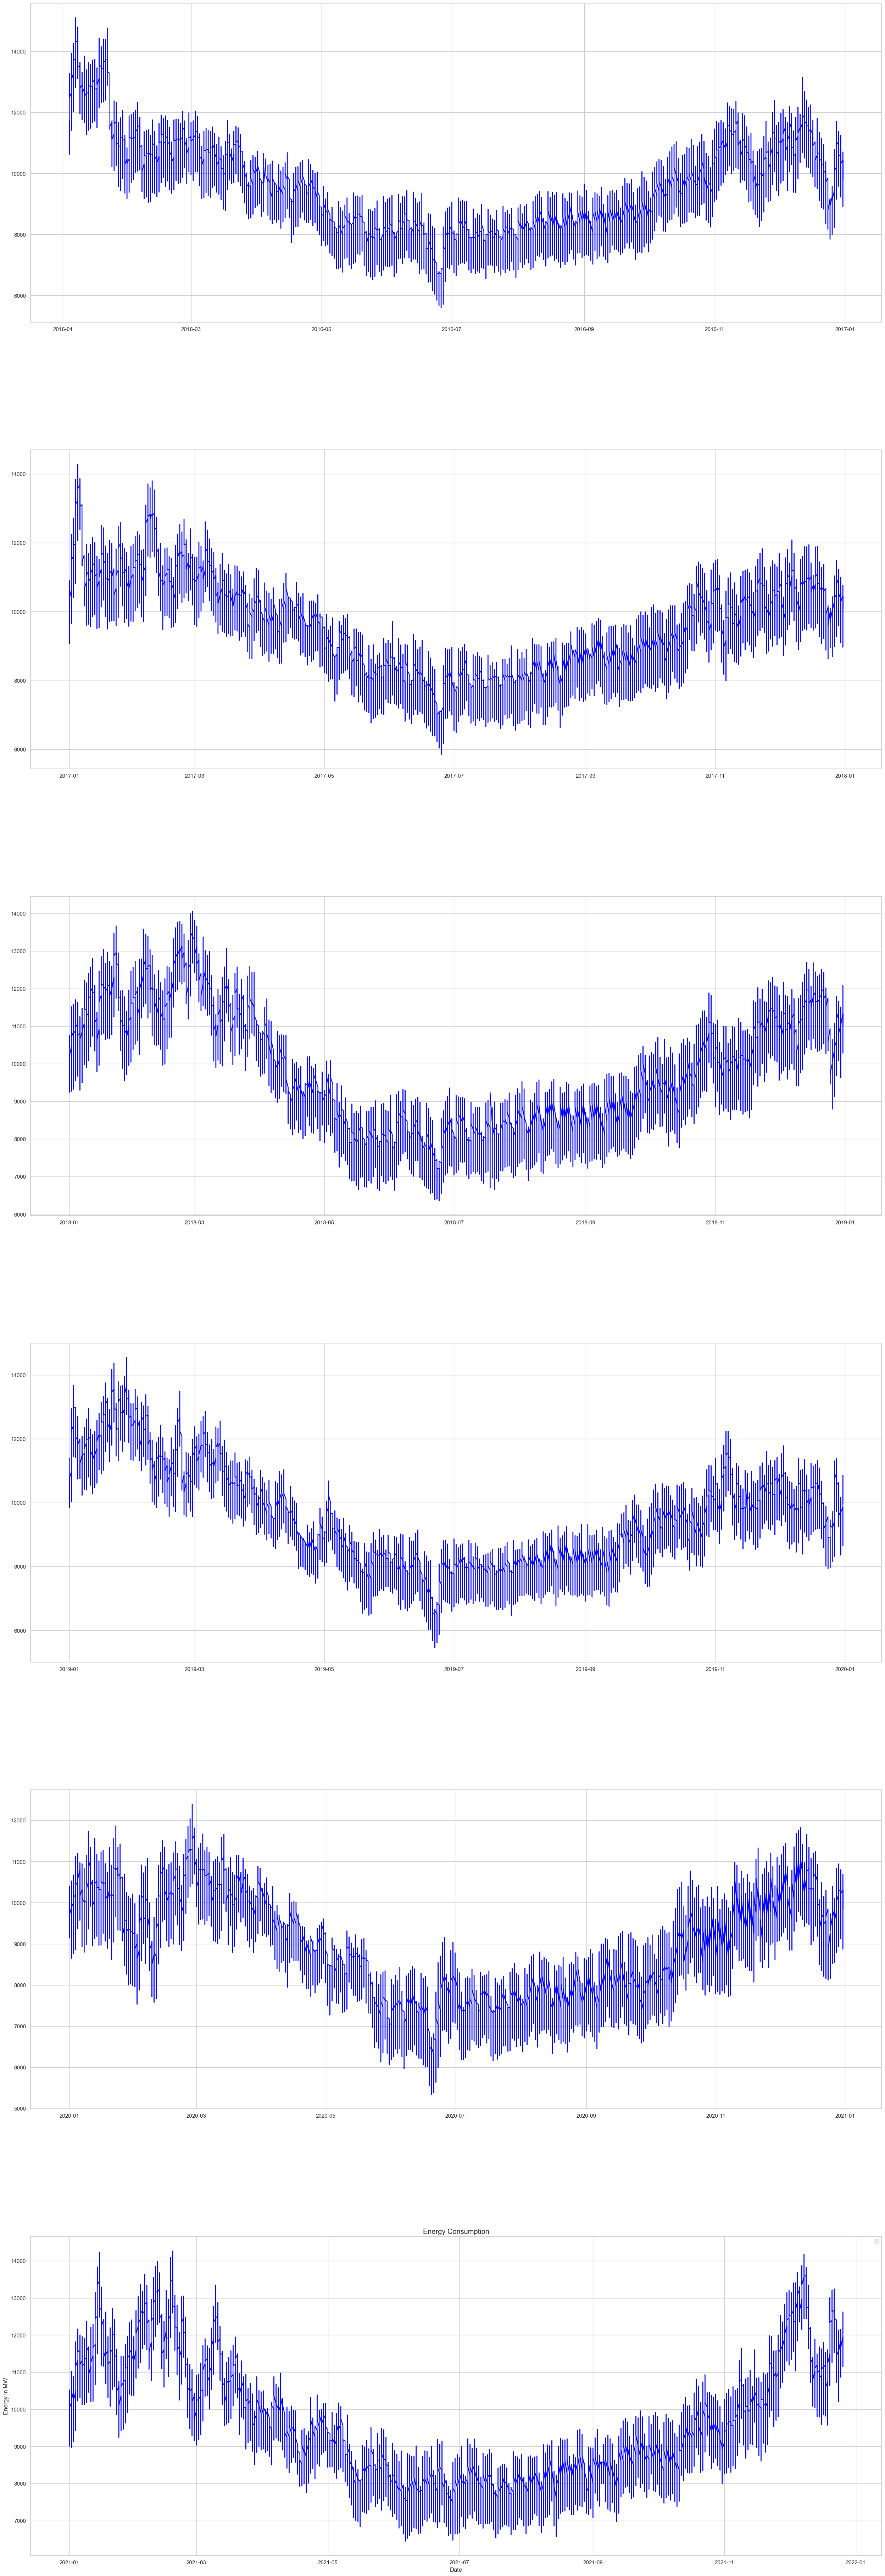

In [15]:
# Energy Consumption Each Year
from matplotlib import style

fig = plt.figure(figsize = (30,30))

ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
ax6 = fig.add_subplot(616)

style.use("ggplot")

y_2016 = dataset.loc["2016"]["Consumption"].to_list()
x_2016 = dataset.loc["2016"]["Date"].to_list()
ax1.plot(x_2016, y_2016, color= "blue", linewidth= 1.7)

y_2017 = dataset.loc["2017"]["Consumption"].to_list()
x_2017 = dataset.loc["2017"]["Date"].to_list()
ax2.plot(x_2017, y_2017, color= "blue", linewidth= 1.7)

y_2018 = dataset.loc["2018"]["Consumption"].to_list()
x_2018 = dataset.loc["2018"]["Date"].to_list()
ax3.plot(x_2018, y_2018, color= "blue", linewidth= 1.7)

y_2019 = dataset.loc["2019"]["Consumption"].to_list()
x_2019 = dataset.loc["2019"]["Date"].to_list()
ax4.plot(x_2019, y_2019, color= "blue", linewidth= 1.7)

y_2020 = dataset.loc["2020"]["Consumption"].to_list()
x_2020 = dataset.loc["2020"]["Date"].to_list()
ax5.plot(x_2020, y_2020, color= "blue", linewidth= 1.7)

y_2021 = dataset.loc["2021"]["Consumption"].to_list()
x_2021 = dataset.loc["2021"]["Date"].to_list()
ax6.plot(x_2021, y_2021, color= "blue", linewidth= 1.7)

plt.rcParams["figure.figsize"] = (30, 15)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=2.5, wspace=0.4, hspace=0.4)
plt.title("Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True, alpha=1)
plt.legend()

C:\Users\marcu\AppData\Local\Temp\ipykernel_8260\1952416682.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["Consumption"])


Text(0.5, 1.0, 'Energy Distribution')

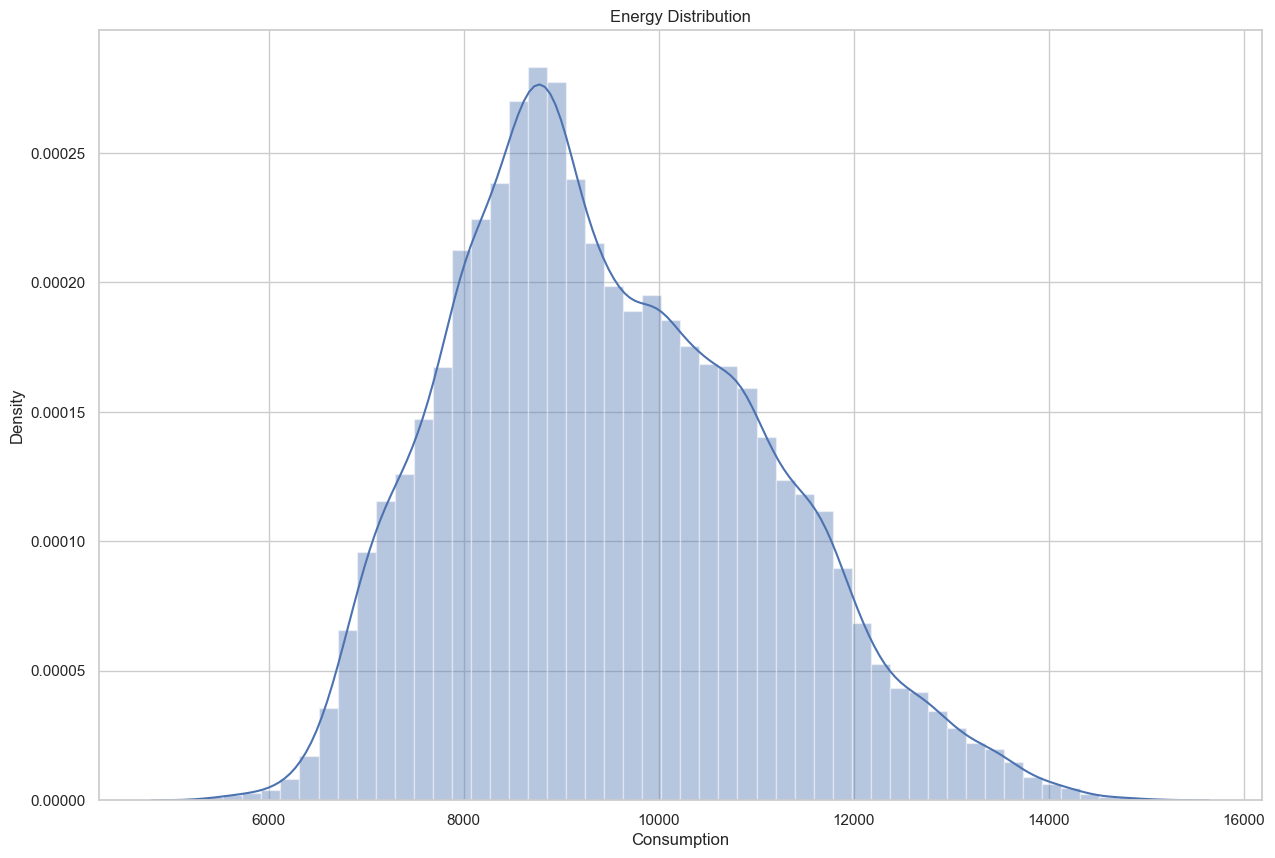

In [35]:
# Lets us see the Distribution off Energy Consumption so we have a idea about your Dataset a bit more
fig = plt.figure(figsize = (15,10))
sns.distplot(dataset["Consumption"])
plt.title("Energy Distribution")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


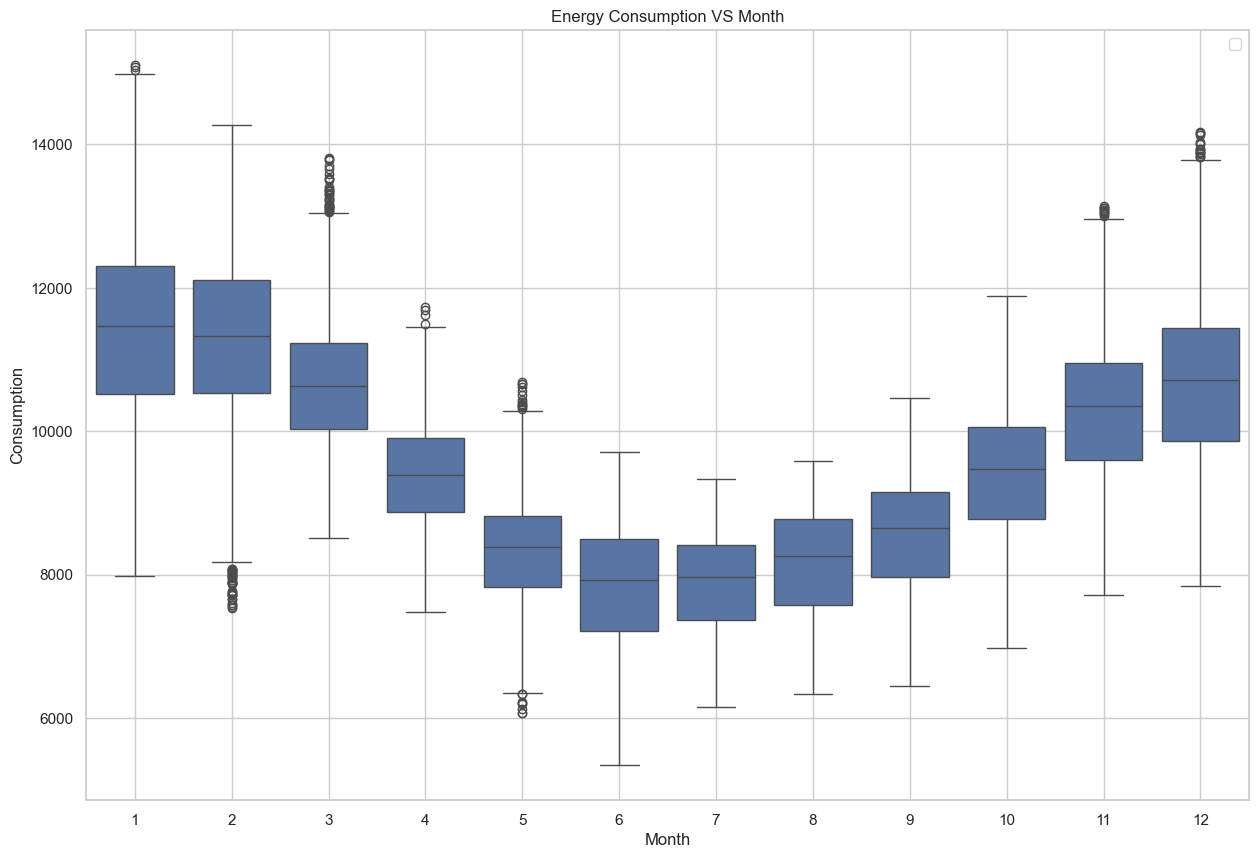

In [36]:
fig = plt.figure(figsize = (15,10))
sns.boxplot(x=dataset["Month"], y=dataset["Consumption"], data= df)
plt.title("Energy Consumption VS Month")
plt.xlabel("Month")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

## Splitting Train and Test Data

In [46]:
X = df[["Month", "Year", "Date", "Time", "Day"]]
y = df["Consumption"]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [49]:
# Ensure X_train and X_test contain only numeric values
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

In [50]:
# Fill missing values with mean (or another strategy)
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## SVM (Support Vector Machine)

In [52]:
svm = SVR(kernel="rbf", C=100, gamma=0.1)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

## Random Forest

In [53]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## RNN (Recurrent Neural Network)

In [55]:
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

rnn_model = Sequential([
    SimpleRNN(50, activation="relu", return_sequences=True, input_shape=(1, X_train.shape[1])),
    SimpleRNN(50, activation="relu"),
    Dense(1)
])
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
rnn_model.fit(X_train_rnn, y_train, epochs=20, batch_size=16, verbose=0)
y_pred_rnn = rnn_model.predict(X_test_rnn).flatten()

332/332 [==============================] - 1s 945us/step


## LSTM (Long short Term Memory)

In [56]:
lstm_model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(1, X_train.shape[1])),
    LSTM(50, activation="relu"),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
lstm_model.fit(X_train_rnn, y_train, epochs=20, batch_size=16, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_rnn).flatten()


332/332 [==============================] - 0s 816us/step


## Model Evaluation

In [57]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    return (model_name, mae, rmse)

results = [
    evaluate_model(y_test, y_pred_svm, "SVM"),
    evaluate_model(y_test, y_pred_rf, "Random Forest"),
    evaluate_model(y_test, y_pred_rnn, "RNN"),
    evaluate_model(y_test, y_pred_lstm, "LSTM")
]

In [58]:
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE"])
print(results_df)


           Model          MAE         RMSE
0            SVM  1336.963422  1659.793450
1  Random Forest   955.590299  1224.964659
2            RNN   849.721955  1068.059504
3           LSTM   965.219684  1256.041496


## Visualisation

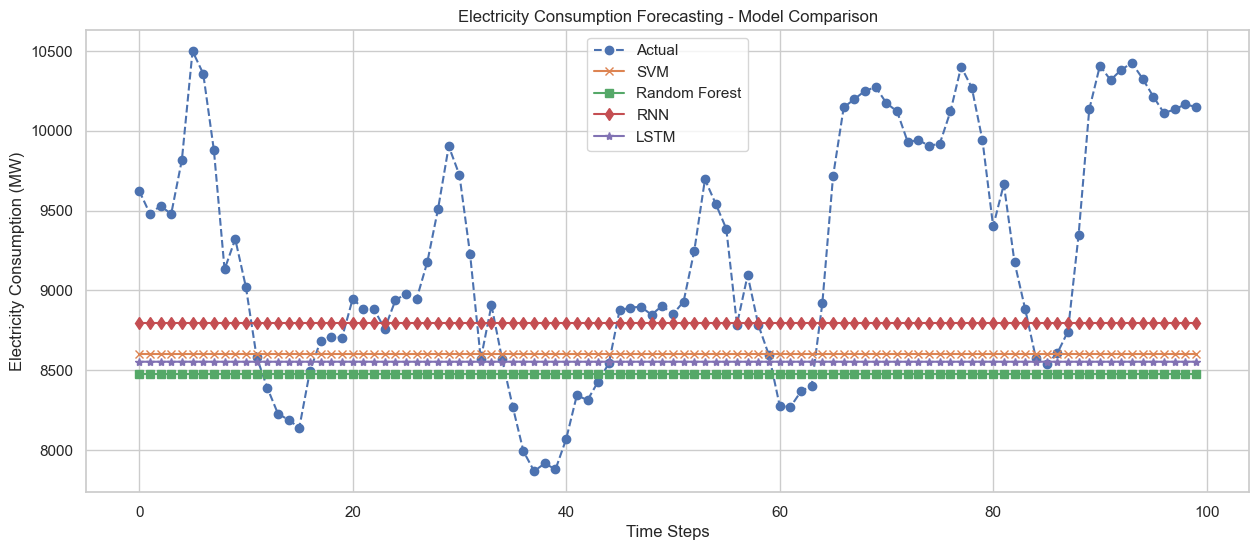

In [59]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label="Actual", linestyle="--", marker='o')
plt.plot(y_pred_svm[:100], label="SVM", linestyle="-", marker='x')
plt.plot(y_pred_rf[:100], label="Random Forest", linestyle="-", marker='s')
plt.plot(y_pred_rnn[:100], label="RNN", linestyle="-", marker='d')
plt.plot(y_pred_lstm[:100], label="LSTM", linestyle="-", marker='*')
plt.xlabel("Time Steps")
plt.ylabel("Electricity Consumption (MW)")
plt.title("Electricity Consumption Forecasting - Model Comparison")
plt.legend()
plt.grid(True)
plt.show()